## Feed Forward Network 
Submitted by Akriti Gupta, Bhumika Singhal and Namita Shukla

In this notebook, we are focusing on creating a shallow consiting of 2 linear layers on which Relu and batch normalization is applied. 

After this we move forward to train our model on a deep network consisting of 4 linear layers on which Relu and Batch Normalization is applied. 

In [1]:
# Here we make all the imports
import pandas as pd
import numpy as np
import random, time
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from tqdm.notebook import tqdm, trange
import seaborn as sns
import json
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix,roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pytorchtools

# Model Definitions

Below we have defined our shallow and Deep layers. We tried different models by increasing and decreasing the number of linear layers. We also tried different dropout values. The following experiment showed us that the best model is the a deep structiure with 4 layers. Moving beyond this we start overfitting 

In [5]:
input_dim = 200
hidden_1 = 1000
hidden_2 = 256
output_dim = 2

class BNShallowNet(nn.Module):
    def __init__(self):
        super(BNShallowNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 2)
        self.bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        # output = F.log_softmax(x, dim=1)
        return x

class BNDeepNet(nn.Module):
    def __init__(self):
        super(BNDeepNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

        #self.fc5 = nn.Linear(32, 2)
        #self.fc6 = nn.Linear(16, 2)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        # x = self.bn4(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc5(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc6(x)
        output = F.log_softmax(x, dim=1)
        return output



The below function is used to divide the datasets into small chunks 

In [6]:
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

This code is used to import the Concat Embeddings of Images and Text and to load the Json files.

In [13]:
concat_embeddings = pd.read_csv("/content/drive/MyDrive/522-project/Embeddings/Retrain-Concat-150T-50I/ConcatEmbeddings_train.csv")
concat_embeddings.rename(columns={"0": "id"}, inplace=True)

In [14]:
train_data = pd.read_json("/content/drive/MyDrive/522-project/train.jsonl", lines=True)
train_data.head()
train_data.shape
batch_size = 32
chunked_data = split_dataframe(train_data, batch_size)

In [15]:
preds_train=[]
target_train =[]
preds_val=[]
target_val=[]

Code for training and validating the models 

In [16]:
def train(args, model, device, chunked_data, optimizer,criterion, concat_embeddings):
    model.train()

    for e in range(args['epochs']): 
      preds_train=[]
      target_train =[]
      avg_loss = 0.
      correct = 0
      total = 0
      for batch_idx, (data) in enumerate(chunked_data):
          id = data.id
          
          target = torch.Tensor(data.label.tolist()).to(device)
          a = concat_embeddings[concat_embeddings.id.isin(id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
          if(len(a)==0):
            continue
          data = torch.Tensor(a).to(device)
          optimizer.zero_grad()
          output = model(data)

          loss = criterion(output, target.type(torch.cuda.LongTensor))
          avg_loss += loss.item()
          
          loss.backward()
          _, predicted = torch.max(output.data, 1)
          total += target.size(0)
          #print(predicted.cpu().numpy())
          #print(target.cpu().numpy())
          # r= confusion_matrix(target.cpu().numpy(), predicted.cpu().numpy())
          p = predicted.cpu().numpy()
          t = target.cpu().numpy()
          
          preds_train.extend(p)
          target_train.extend(t)
         

          correct += (predicted.cpu() == target.cpu()).sum()
          optimizer.step()
      #print(preds_train)
      avg_loss /= len(chunked_data)
      print("Epoch : " + str(e)  + "  loss : " + str(avg_loss))
      precision, recall, f1, _ = precision_recall_fscore_support(preds_train, target_train, average='binary')
      r= confusion_matrix(preds_train, target_train)
      print(" precision :"+str(precision) +" recall :"+str(recall)+" f1 "+ str(f1))
      print("confusion_matrix")
      print(r)

      roc_auc = roc_auc_score(preds_train, target_train)
      print("roc",roc_auc)
      accuracy = 100.00 * correct.numpy() / total
      print("Epoch : " + str(e)  + "  accuracy : " + str(accuracy))


In [17]:
def post_train(args, model, device, chunked_data,criterion, concat_embeddings):
    model.eval()

    avg_loss = 0.
    correct = 0
    total = 0
    preds_val=[]
    target_val=[]
    for batch_idx, (data) in enumerate(chunked_data):
        id = data.id
        target = torch.Tensor(data.label.tolist()).to(device)
        a = concat_embeddings[concat_embeddings.id.isin(id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
        if(len(a)==0):
          continue
        data = torch.Tensor(a).to(device)
        output = model(data)
        #print(output.shape,target.shape)


        loss = criterion(output, target.type(torch.cuda.LongTensor))
        avg_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted.cpu() == target.cpu()).sum()
        p = predicted.cpu().numpy()
        t = target.cpu().numpy()
        preds_val.extend(p)
        target_val.extend(t)

    avg_loss /= len(chunked_data)
    precision, recall, f1, _ = precision_recall_fscore_support(preds_val, target_val, average='binary')
    precision1, recall1, thresholds = precision_recall_curve(preds_val, target_val)
    r= confusion_matrix(preds_val, target_val)
    accuracy = 100.00 * correct.numpy() / total
    fpr, tpr, _ = roc_curve(target_val, preds_val)

    print( "  accuracy : " + str(accuracy))
    print("  loss : " + str(avg_loss))
    print(" precision :"+str(precision) +" recall :"+str(recall)+" f1 "+ str(f1))
    print("confusion_matrix")
    print(r)
    roc_auc = roc_auc_score(preds_val, target_val)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)

    for i in range(r.shape[0]):
      for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
    
    print("roc",roc_auc)
    #plt.figure(1)

    #sns.heatmap(r,annot=True)
    plt.show()


    pyplot.plot(recall1, precision1, marker='.', label='Shallow_net')
    # axis labels
    print("Precison Vs Recall")
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    pyplot.title('Precision Vs Recall', fontsize=20)
    # show the plot
    pyplot.show()

    print("ROC")

    # plt.plot([0, 1], [0, 1], 'k–')
    plt.plot(fpr, tpr, label='FNN_ROC(area = {:.3f})'.format(roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()




# Shallow : Train

In [18]:

model_shallow = BNShallowNet().to('cuda')
args = {'lr': 0.1, 'momentum': 0.1, "epochs" : 20}
optimizer = optim.SGD(model_shallow.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"

train(args, model_shallow, device, chunked_data, optimizer, criterion, concat_embeddings)

Epoch : 0  loss : 0.6952407446206736
 precision :0.23087114938721431 recall :0.42063971031985514 f1 0.2981180496150556
confusion_matrix
[[4521 2322]
 [ 960  697]]
roc 0.5406574264006114
Epoch : 0  accuracy : 61.38823529411765
Epoch : 1  loss : 0.6882159336841196
 precision :0.22524014574362372 recall :0.4441541476159373 f1 0.2989010989010989
confusion_matrix
[[4630 2339]
 [ 851  680]]
roc 0.5542624662602574
Epoch : 1  accuracy : 62.470588235294116
Epoch : 2  loss : 0.6753278017548242
 precision :0.23716462404769792 recall :0.45897435897435895 f1 0.3127320375627866
confusion_matrix
[[4637 2303]
 [ 844  716]]
roc 0.5635649892854504
Epoch : 2  accuracy : 62.976470588235294
Epoch : 3  loss : 0.6674903873214149
 precision :0.24643921828420007 recall :0.48186528497409326 f1 0.32610124917817224
confusion_matrix
[[4681 2275]
 [ 800  744]]
roc 0.5774047528953272
Epoch : 3  accuracy : 63.8235294117647
Epoch : 4  loss : 0.654587147575348
 precision :0.25935740311361377 recall :0.49619771863117873

# Shallow : Validation

Running the validation loss and accuarcy on the concat embeddings of dev seen and dev unseen csv

  accuracy : 43.333333333333336
  loss : 0.9820492758470423
 precision :0.97 recall :0.39271255060728744 f1 0.5590778097982708
confusion_matrix
[[ 40   6]
 [300 194]]
roc 0.631138883999296


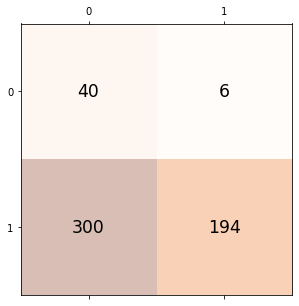

Precison Vs Recall


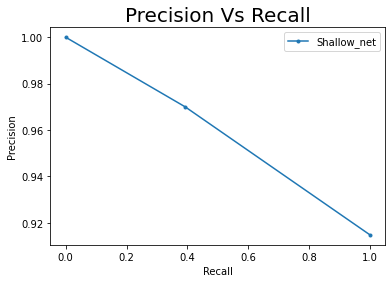

ROC


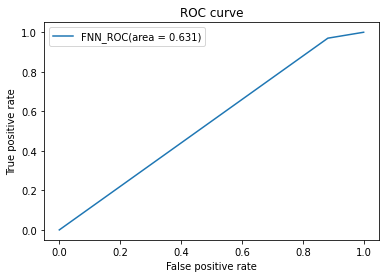

In [19]:

validation_paths = ["/content/drive/MyDrive/522-project/Embeddings/Retrain-Concat-150T-50I/ConcatEmbeddings_dev_unseen.csv"]
concat_embeddings_validation = pd.concat( map(pd.read_csv, validation_paths), ignore_index=True)
concat_embeddings_validation.head()
concat_embeddings_validation.rename(columns={"0": "id"}, inplace=True)
batch_size = 32
val_data_unseen = pd.read_json("/content/drive/MyDrive/522-project/dev_unseen.jsonl", lines=True)

val_data_unseen = val_data_unseen[val_data_unseen.id.isin(concat_embeddings_validation.id)]
chunked_data_validation = split_dataframe(val_data_unseen, batch_size)


args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_shallow, device, chunked_data_validation,criterion, concat_embeddings_validation)


# Shallow : Test Unseen


  accuracy : 39.75
  loss : 1.0818456224505864
 precision :0.9533333333333334 recall :0.3793103448275862 f1 0.5426944971537002
confusion_matrix
[[  80   35]
 [1170  715]]
roc 0.5374812593703149


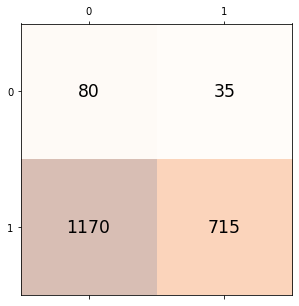

Precison Vs Recall


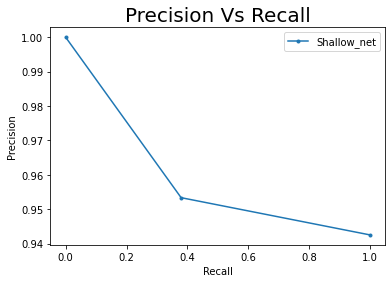

ROC


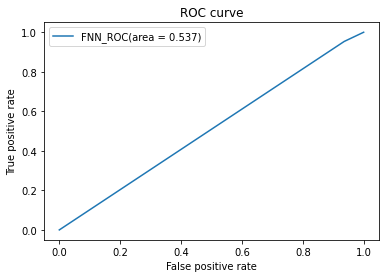

In [20]:
test_unseen_paths = ["/content/drive/MyDrive/522-project/Embeddings/Retrain-Concat-150T-50I/ConcatEmbeddings_test_unseen.csv"]

concat_embeddings_test_unseen = pd.concat( map(pd.read_csv, test_unseen_paths), ignore_index=True)
concat_embeddings_test_unseen.rename(columns={"0": "id"}, inplace=True)

batch_size = 32
test_data_unseen = pd.read_json("/content/drive/MyDrive/522-project/test_unseen.jsonl", lines=True)

test_data_unseen = test_data_unseen[test_data_unseen.id.isin(concat_embeddings_test_unseen.id)]
chunked_data_test_unseen = split_dataframe(test_data_unseen, batch_size)

args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_shallow, device, chunked_data_test_unseen,criterion, concat_embeddings_test_unseen)

# Shallow: Test Seen

  accuracy : 55.2
  loss : 0.7498102327808738
 precision :0.9489795918367347 recall :0.5236486486486487 f1 0.6748911465892599
confusion_matrix
[[ 87  25]
 [423 465]]
roc 0.6502171814671814


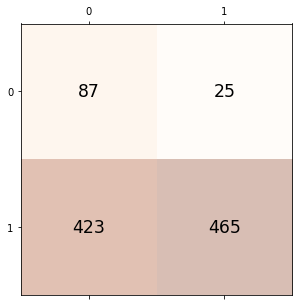

Precison Vs Recall


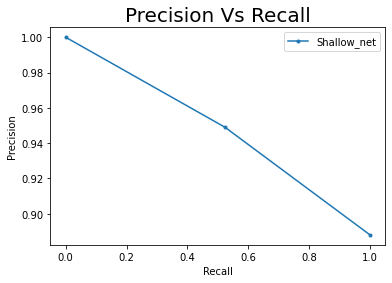

ROC


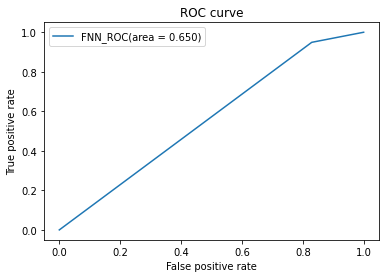

In [21]:
test_seen_paths = ["/content/drive/MyDrive/522-project/Embeddings/Retrain-Concat-150T-50I/ConcatEmbeddings_test_seen.csv"]

concat_embeddings_test_seen = pd.concat( map(pd.read_csv, test_seen_paths), ignore_index=True)
concat_embeddings_test_seen.rename(columns={"0": "id"}, inplace=True)

batch_size = 32
test_data_seen = pd.read_json("/content/drive/MyDrive/522-project/test_seen.jsonl", lines=True)

test_data_seen = test_data_seen[test_data_seen.id.isin(concat_embeddings_test_seen.id)]
chunked_data_test_seen = split_dataframe(test_data_seen, batch_size)

args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_shallow, device, chunked_data_test_seen,criterion, concat_embeddings_test_seen)

# Deep Model : Training

In [22]:
import json
model_deep = BNDeepNet().to('cuda')
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
optimizer = optim.SGD(model_deep.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"

train(args, model_deep, device, chunked_data, optimizer, criterion, concat_embeddings)

Epoch : 0  loss : 0.6967967421488654
 precision :0.1517058628684995 recall :0.318941504178273 f1 0.20561167227833896
confusion_matrix
[[4503 2561]
 [ 978  458]]
roc 0.4781995176610504
Epoch : 0  accuracy : 58.36470588235294
Epoch : 1  loss : 0.6557852713237131
 precision :0.009605829744948658 recall :0.31868131868131866 f1 0.01864951768488746
confusion_matrix
[[5419 2990]
 [  62   29]]
roc 0.4815549535492454
Epoch : 1  accuracy : 64.09411764705882
Epoch : 2  loss : 0.6530317885983259
 precision :0.01093077177873468 recall :0.44594594594594594 f1 0.02133850630455868
confusion_matrix
[[5440 2986]
 [  41   33]]
roc 0.5457833218929825
Epoch : 2  accuracy : 64.38823529411765
Epoch : 3  loss : 0.6514047647553279
 precision :0.005631003643590593 recall :0.5151515151515151 f1 0.011140235910878114
confusion_matrix
[[5465 3002]
 [  16   17]]
roc 0.5802992723980087
Epoch : 3  accuracy : 64.49411764705883
Epoch : 4  loss : 0.650487833677378
 precision :0.002649884067572044 recall :0.30769230769230

# Deep Model: Validation

  accuracy : 54.81481481481482
  loss : 0.6889076548464158
 precision :0.08 recall :0.21052631578947367 f1 0.11594202898550725
confusion_matrix
[[280 184]
 [ 60  16]]
roc 0.4069872958257713


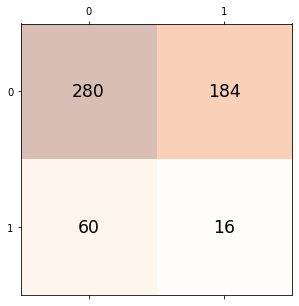

Precison Vs Recall


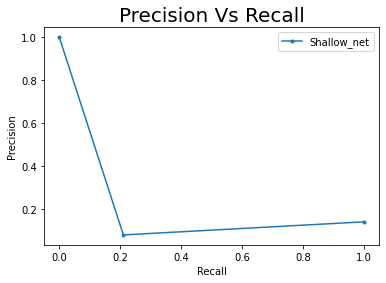

ROC


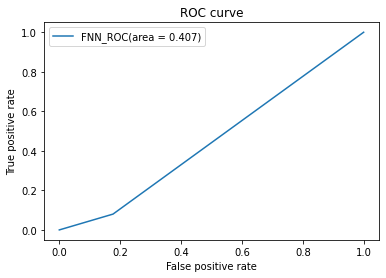

In [23]:
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_deep, device, chunked_data_validation,criterion, concat_embeddings_validation)


# Deep Model: Test Seen 

  accuracy : 49.5
  loss : 0.7067496534436941
 precision :0.0673469387755102 recall :0.4074074074074074 f1 0.11558669001751315
confusion_matrix
[[462 457]
 [ 48  33]]
roc 0.4550638778059887


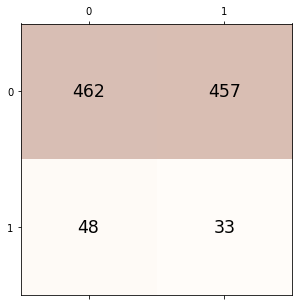

Precison Vs Recall


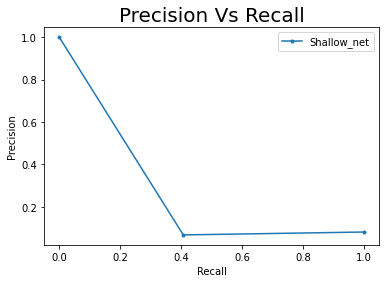

ROC


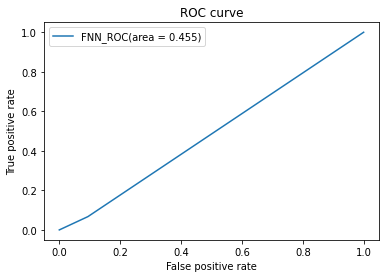

In [24]:
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_deep, device, chunked_data_test_seen,criterion, concat_embeddings_test_seen)

# Deep Model: Test UnSeen

  accuracy : 56.8
  loss : 0.6862882205418178
 precision :0.11866666666666667 recall :0.3047945205479452 f1 0.17082533589251436
confusion_matrix
[[1047  661]
 [ 203   89]]
roc 0.4588960893137852


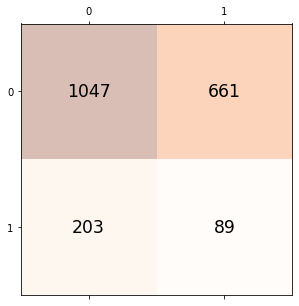

Precison Vs Recall


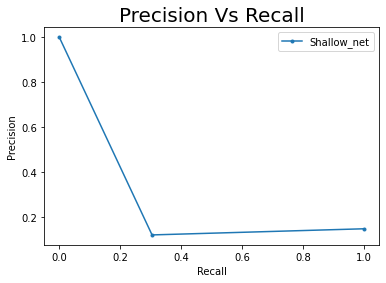

ROC


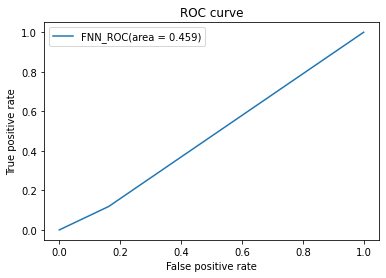

In [25]:
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_deep, device, chunked_data_test_unseen,criterion, concat_embeddings_test_unseen)